In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
import warnings
warnings.filterwarnings('ignore')

# Загрузка данных
df = pd.read_csv('buildings_classified_optimal_value2.csv')
# Преобразование ready в булев тип
df['ready'] = pd.to_numeric(df['ready'], errors='coerce').fillna(0).astype(bool)
# Создание новых признаков
df['log_price_per_sqm'] = np.log(df['price_per_m2'])
# Вычисление floor_perc с обработкой деления на ноль
df['floor_perc'] = df['floor_current'] / df['floor_total']

# Преобразование булевых признаков в числовые
names_bool = ['ready', 'is_city', 'popular_developer', 'court', 'entrance', 'parking', 'parks']
for name in names_bool:
    if name in df.columns:
        df[name] = pd.to_numeric(df[name], errors='coerce').fillna(0).astype(int)

# Удаление пропусков в признаках
df.dropna(subset=['total_area', 'floor_perc', 'log_price_per_sqm'], inplace=True)

# Числовые признаки
numeric_features = ['floor_perc', 'total_area']
# Булевы признаки
bool_features = ['is_city', 'ready', 'popular_developer', 'court', 'entrance', 'parking', 'parks']
bool_features = [f for f in bool_features if f in df.columns]

# Масштабируем только настоящие числовые признаки
scaler = StandardScaler()
numeric_scaled = scaler.fit_transform(df[numeric_features])

# Объединяем признаки
X = np.hstack([numeric_scaled, df[bool_features].values])

# Целевая переменная
y = df['log_price_per_sqm'].values

# Обучение Lasso с кросс-валидацией
lasso = LassoCV(cv=5, max_iter=10000, random_state=42, n_alphas=50)
lasso.fit(X, y)
# Получение имен признаков
all_feature_names = numeric_features + bool_features
# Создание DataFrame с коэффициентами
coef_df = pd.DataFrame({
    'feature': all_feature_names,
    'coefficient': lasso.coef_,
    'premium_percent': np.exp(lasso.coef_) - 1  # Перевод в %
})

# Фильтрация ненулевых коэффициентов
coef_df = coef_df[coef_df['coefficient'] != 0].sort_values('coefficient', ascending=False)

print("Важные признаки для предсказания цены за квадратный метр:")
print(coef_df)
print(f"\nЛучший alpha (регуляризация): {lasso.alpha_:.6f}")
print(f"R² на обучении: {lasso.score(X, y):.4f}")
print(f"Количество ненулевых коэффициентов: {(lasso.coef_ != 0).sum()}")

# Анализ по кластерам
if 'cluster' in df.columns:
    clusters = df['cluster'].unique()
    
    for cluster_id in clusters:
        print(f"\nАнализ для кластера {cluster_id}:")
        
        cluster_mask = df['cluster'] == cluster_id
        X_cluster = X[cluster_mask]
        y_cluster = y[cluster_mask]
        
        lasso_cluster = LassoCV(
            cv=min(5, len(y_cluster)//3), 
            max_iter=10000, 
            random_state=42,
            n_alphas=20
        )
        lasso_cluster.fit(X_cluster, y_cluster)
                
        coef_cluster_df = pd.DataFrame({
            'feature': all_feature_names,
            'coefficient': lasso_cluster.coef_,
            'premium_percent': np.exp(lasso_cluster.coef_) - 1
        })
                
        non_zero_coefs = coef_cluster_df[coef_cluster_df['coefficient'] != 0]
                
        if len(non_zero_coefs) > 0:
            non_zero_coefs = non_zero_coefs.sort_values('coefficient', ascending=False)
            print(f"Важные признаки для кластера {cluster_id}:")
            print(non_zero_coefs)
            print(f"R² для кластера: {lasso_cluster.score(X_cluster, y_cluster):.4f}")
        else:
            print(f"Все коэффициенты равны нулю")

Важные признаки для предсказания цены за квадратный метр:
      feature  coefficient  premium_percent
2     is_city     0.268982         0.308631
1  total_area     0.069655         0.072139
6    entrance     0.037022         0.037716
0  floor_perc     0.032351         0.032880
3       ready    -0.023655        -0.023377

Лучший alpha (регуляризация): 0.039506
R² на обучении: 0.3594
Количество ненулевых коэффициентов: 5

Анализ для кластера 0:
Важные признаки для кластера 0:
             feature  coefficient  premium_percent
2            is_city     0.147426         0.158848
4  popular_developer     0.129222         0.137942
6           entrance     0.124056         0.132079
7            parking     0.017190         0.017339
0         floor_perc     0.017011         0.017156
8              parks    -0.003964        -0.003956
3              ready    -0.126079        -0.118455
5              court    -0.164705        -0.151856
1         total_area    -0.302443        -0.260989
R² для клас

In [2]:
# Создание карт ценности
if 'cluster' in df.columns:
    # Создаем копию данных для безопасной работы
    df_analysis = df.copy()
    # Создаем словарь для хранения моделей каждого кластера
    cluster_models = {}
    cluster_predictions = {}
    # Для каждого кластера создаем свою модель и делаем предсказания
    for cluster_id in sorted(df_analysis['cluster'].unique()):
        # Выбираем данные кластера
        cluster_mask = df_analysis['cluster'] == cluster_id
        X_cluster = X[cluster_mask]
        y_cluster = y[cluster_mask]
        # Создаем и обучаем модель для кластера
        lasso_cluster = LassoCV(
            cv=min(5, len(y_cluster)//3),
            max_iter=10000,
            random_state=42,
            n_alphas=20
        )
        lasso_cluster.fit(X_cluster, y_cluster)
        # Сохраняем модель
        cluster_models[cluster_id] = lasso_cluster
        # Предсказываем значения
        y_pred_cluster = lasso_cluster.predict(X_cluster)
        # Вычисляем соответствие JTBD как нормализованную оценку от 0 до 100%
        mae = np.abs(y_cluster - y_pred_cluster)
        if mae.max() > 0:
            jtbd_score = 100 * (1 - (mae / mae.max()))
        else:
            jtbd_score = np.full_like(y_cluster, 100)
        # Сохраняем предсказания и оценки соответствия
        cluster_indices = df_analysis[cluster_mask].index
        for idx, jtbd, pred_price in zip(cluster_indices, jtbd_score, y_pred_cluster):
            cluster_predictions[idx] = {
                'cluster': cluster_id,
                'jtbd_score': jtbd,
                'pred_log_price': pred_price,
                'actual_log_price': y[df_analysis.index.get_loc(idx)] if idx in df_analysis.index else None
            }

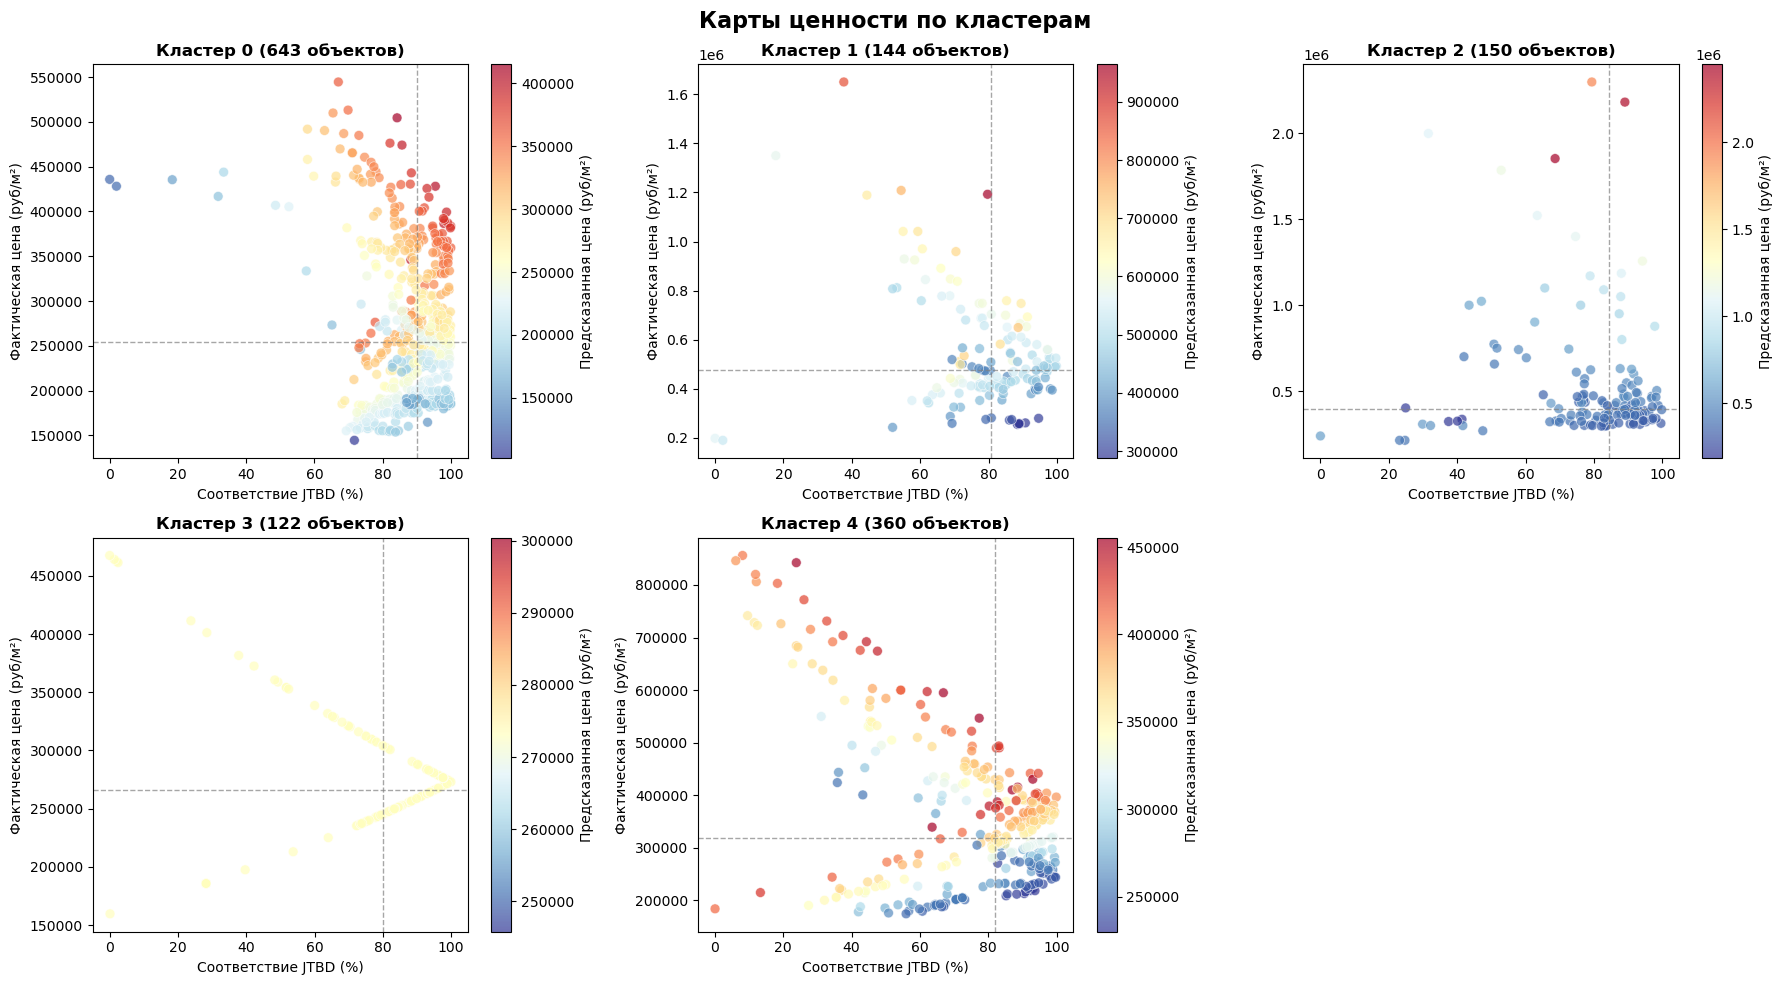

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
    
# Создаем колонки в DataFrame
df_analysis['jtbd_score'] = np.nan
df_analysis['pred_log_price'] = np.nan
    
# Заполняем данные из предсказаний
for idx, pred_data in cluster_predictions.items():
    if idx in df_analysis.index:
        df_analysis.at[idx, 'jtbd_score'] = pred_data['jtbd_score']
        df_analysis.at[idx, 'pred_log_price'] = pred_data['pred_log_price']
    
# Удаляем строки с пропусками
df_analysis_clean = df_analysis.dropna(subset=['jtbd_score', 'pred_log_price', 'price_per_m2'])
    
# Преобразуем предсказанный логарифм цены обратно в обычную цену
df_analysis_clean['pred_price_per_m2'] = np.exp(df_analysis_clean['pred_log_price'])
    
# Построение карт
clusters_to_plot = sorted(df_analysis_clean['cluster'].unique())
    
if len(clusters_to_plot) > 0:
    # Определяем оптимальное количество строк и колонок для subplots
    n_clusters = len(clusters_to_plot)
    n_cols = min(3, n_clusters)
    n_rows = (n_clusters + n_cols - 1) // n_cols
        
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows), squeeze=False)
    fig.suptitle('Карты ценности по кластерам', fontsize=16, fontweight='bold')
        
    for idx, cluster_id in enumerate(clusters_to_plot):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col]
            
        # Выбираем данные кластера
        cluster_data = df_analysis_clean[df_analysis_clean['cluster'] == cluster_id]
            
        # Вычисляем медианные значения для разделения на квадранты
        median_jtbd = cluster_data['jtbd_score'].median()
        median_price = cluster_data['price_per_m2'].median()
            
        # Создаем scatter plot
        scatter = ax.scatter(
            cluster_data['jtbd_score'],
            cluster_data['price_per_m2'],
            c=cluster_data['pred_price_per_m2'],  # Цвет по предсказанной цене
            cmap='RdYlBu_r',
            alpha=0.7,
            s=50,
            edgecolors='w',
            linewidth=0.5
        )
            
        # Добавляем цветовую шкалу
        plt.colorbar(scatter, ax=ax, label='Предсказанная цена (руб/м²)')
            
        # Добавляем линии квадрантов
        ax.axhline(y=median_price, color='gray', linestyle='--', alpha=0.7, linewidth=1)
        ax.axvline(x=median_jtbd, color='gray', linestyle='--', alpha=0.7, linewidth=1)
            
        # Настройки графика
        ax.set_xlabel('Соответствие JTBD (%)', fontsize=10)
        ax.set_ylabel('Фактическая цена (руб/м²)', fontsize=10)
        ax.set_title(f'Кластер {cluster_id} ({len(cluster_data)} объектов)', fontsize=12, fontweight='bold')
        
    # Убираем лишние оси, если они есть
    for idx in range(len(clusters_to_plot), n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        axes[row, col].axis('off')
        
    plt.tight_layout()
    plt.show()

In [4]:
# Сохраняем каждый subplot как отдельное изображение
for idx, cluster_id in enumerate(clusters_to_plot):
    row = idx // n_cols
    col = idx % n_cols
    
    if idx < len(clusters_to_plot):
        # Создаем новую фигуру для каждого кластера
        fig_single, ax_single = plt.subplots(figsize=(10, 8))
        
        # Копируем данные из соответствующего subplot
        cluster_data = df_analysis_clean[df_analysis_clean['cluster'] == cluster_id]
        
        if len(cluster_data) >= 5:
            median_jtbd = cluster_data['jtbd_score'].median()
            median_price = cluster_data['price_per_m2'].median()
            
            # Воссоздаем scatter plot
            scatter = ax_single.scatter(
                cluster_data['jtbd_score'],
                cluster_data['price_per_m2'],
                c=cluster_data['pred_price_per_m2'],
                cmap='RdYlBu_r',
                alpha=0.7,
                s=70,  # Немного увеличиваем размер точек
                edgecolors='w',
                linewidth=0.5
            )
            
            # Цветовая шкала
            cbar = plt.colorbar(scatter, ax=ax_single)
            cbar.set_label('Предсказанная цена (руб/м²)', fontsize=11)
            
            # Линии квадрантов
            ax_single.axhline(y=median_price, color='gray', linestyle='--', alpha=0.8, linewidth=1.5)
            ax_single.axvline(x=median_jtbd, color='gray', linestyle='--', alpha=0.8, linewidth=1.5)
            
            # Настройки
            ax_single.set_xlabel('Соответствие JTBD (%)', fontsize=12)
            ax_single.set_ylabel('Фактическая цена (руб/м²)', fontsize=12)
            ax_single.set_title(f'Карта ценности: Кластер {cluster_id}\n({len(cluster_data)} объектов)', 
                              fontsize=14, fontweight='bold', pad=15)
            
            # Добавляем статистику в подпись
            stats_text = (f'Медиана JTBD: {median_jtbd:.1f}%\n'
                         f'Медиана цены: {median_price:,.0f} руб/м²')
            ax_single.text(0.02, -0.12, stats_text, transform=ax_single.transAxes,
                          fontsize=9, verticalalignment='top',
                          bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.3))
            
            fig_single.tight_layout()
            fig_single.savefig(f'cluster_{cluster_id}.png', dpi=300, bbox_inches='tight')
            
            plt.close(fig_single)